# Final Capstone Project - The Battle of the Neighborhoods

## Introduction (Problem Description)

A Friend of mine is the manager of a Gym Franchise in the City of Belém - PA, Brazil. He's looking for a good place at the City Center to open a new Gym and expand his business, but has problems finding which neighborhood would be a good one for that.

In this project we will try to look into the City Center to determine its venues as well as good places with few Gyms to open the friend's new Gym. We'll also explore the most common venues of the city center.

It's possible to use this kind of data to look deeper into cities around the world to explore and analyse them. Some possible applications are: look for similarity between neighborhoods, analyse neighborhood venues to recommend good places to open/set new stores, search for places to stay near your favorites kind of venues when you're traveling, and more. 

This project can be used for stakeholders to choose some of the best places in a city to open their business.

## Data Description

<b>1 - Get the center of the City:</b> We'll be using BeautifulSoup to get the city center neighborhood from the following page: https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Bel%C3%A9m_(Par%C3%A1). After, the data will be used to create our Data Frame and explore it.

<b>2 - Coordinates:</b> We'll need to extract the coordinates(Latitude and Longitude) from the Neighborhood so we can use it to create our maps.

<b>3 - Foursquare:</b> The Foursquare API will be used to search for the venues.

<b>4 - K-Means:</b> At the end, the data will also be clustered with the K-Means algorithm for further analysis.

With the data in hand we'll use it to find possible good places for our friend to open his new Gym.

In [1]:
#First - Import Libraries
import numpy as np #Handle data in a vectorized manner

import pandas as pd #Data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!pip install geopy
from geopy.geocoders import Nominatim #To Convert an address into latitude and longitude values

import requests #Handle requests

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium

#!pip install wget
import wget

%matplotlib inline 

In [2]:
#Import BeautifulSoup to get data from the HTML page
from bs4 import BeautifulSoup

### Let's use the BeautifulSoup to get the text of the page with the Neighborhood of Belém

In [3]:
belem_wiki_url = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Bel%C3%A9m_(Par%C3%A1)').text
soup = BeautifulSoup(belem_wiki_url, "lxml")

In [4]:
#Using soup manipulation to find the correct data that we need
soup.find('tbody').find_all('tr')[1]

<tr><th class="navbox-group" scope="row" style="width:1%;background: #DCDCDC;">Centro</th><td class="navbox-list navbox-odd" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em"><a href="/wiki/Batista_Campos" title="Batista Campos">Batista Campos</a> • <a href="/wiki/Campina_(Bel%C3%A9m)" title="Campina (Belém)">Campina</a> • <a href="/wiki/Cidade_Velha_(Bel%C3%A9m)" title="Cidade Velha (Belém)">Cidade Velha</a> • <a href="/wiki/Marco_(Bel%C3%A9m)" title="Marco (Belém)">Marco</a> • <a href="/wiki/Nazar%C3%A9_(Bel%C3%A9m)" title="Nazaré (Belém)">Nazaré</a> • <a href="/wiki/Reduto_(Bel%C3%A9m)" title="Reduto (Belém)">Reduto</a> • <a href="/wiki/S%C3%A3o_Br%C3%A1s_(Bel%C3%A9m)" title="São Brás (Belém)">São Brás</a> • <a href="/wiki/Umarizal_(Bel%C3%A9m)" title="Umarizal (Belém)">Umarizal</a></div></td></tr>

### Getting the neighborhood and Creating our DataFrame

In [5]:
#Get Belem Boroughs
belem_neighborhood = []

belem_neighborhood = soup.find('tbody').find_all('tr')[1].text.split('•')

In [6]:
#Let's remove 'Centro' from the first string
belem_neighborhood[0] = belem_neighborhood[0].replace('Centro', '')
print(belem_neighborhood)

['Batista Campos ', ' Campina ', ' Cidade Velha ', ' Marco ', ' Nazaré ', ' Reduto ', ' São Brás ', ' Umarizal']


In [7]:
#Define columns names for the data Frame
columns_names = ['Neighborhood', 'Latitude', 'Longitude']

In [8]:
#Creating the Data Frame
df_belem = pd.DataFrame(columns=columns_names)

In [9]:
#Verify
df_belem

,Neighborhood,Latitude,Longitude


### Let's define a function to get the coordinates of the Boroughs

In [10]:
#Function to get Latitude and Longitude
def get_lat_long(address):
    try:
        geolocator = Nominatim(user_agent="to_explorer")
        
        #The Coordinates of "Nazaré" and "Campina" are wrong when we use Geopy
        #So let's use the main spots for both of them to get the right coordinates
        if 'Nazaré' in address:
            location = geolocator.geocode('Basílica, Belém, PA')
        elif 'Campina' in address:
            location = geolocator.geocode('Praça da República, Belém, PA')
        else:
            location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        return [latitude, longitude]
    except:
        return ['No coordinates', 'No coordinates']

### Let's populate the table with the data

In [11]:
#Populate the table
for bor in belem_neighborhood:
    lat_long = get_lat_long('{}, Belém, PA'.format(bor))
    df_belem = df_belem.append({'Neighborhood':bor,
                               'Latitude':lat_long[0],
                               'Longitude':lat_long[1]}, ignore_index=True)
    

In [12]:
#Verify
df_belem

,Neighborhood,Latitude,Longitude
0,Batista Campos,-1.460969,-48.489139
1,Campina,-1.451762,-48.494757
2,Cidade Velha,-1.461945,-48.502750
3,Marco,-1.436286,-48.458978
4,Nazaré,-1.452590,-48.480983
5,Reduto,-1.446291,-48.492163
6,São Brás,-1.451043,-48.471383
7,Umarizal,-1.439893,-48.484956


#### Now we have everything to start

### Let's use the Folium Library to Create the map of the City

In [13]:
#Let's show a map of Belém
belem_lat_long = get_lat_long('Belém, Pará')
map_belem = folium.Map(location=belem_lat_long, zoom_start=11)

#Add markers to map
for lat, long, borough in zip(df_belem['Latitude'], df_belem['Longitude'], df_belem['Neighborhood']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_belem)  
    
map_belem

### We need to use the Foursquare API to get the nearby venues

In [14]:
#The Data we need to use the Foursquare API
CLIENT_ID = 'XJ5AAUCFOG1ZKM3KU3KPGOMDCCECFU1CHETJBBG4RAFZ3QQN' # Foursquare ID
CLIENT_SECRET = 'V20SUSQUEPJVXQN3NZ0Z0UYIUNJSQLXK2OGFJXJKIKTOIXVP' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: XJ5AAUCFOG1ZKM3KU3KPGOMDCCECFU1CHETJBBG4RAFZ3QQN
CLIENT_SECRET:V20SUSQUEPJVXQN3NZ0Z0UYIUNJSQLXK2OGFJXJKIKTOIXVP


### Now we create a function to get the nearby venues from the neighborhoods

In [15]:
LIMIT = 100 #Limit of venues
radius = 600 #within 600 meters

#Function to get the Venues
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Creating the DataFrame with the venues

In [16]:
belem_center_venues = getNearbyVenues(names=df_belem['Neighborhood'],
                                   latitudes=df_belem['Latitude'],
                                   longitudes=df_belem['Longitude']
                                  )

Batista Campos 
 Campina 
 Cidade Velha 
 Marco 
 Nazaré 
 Reduto 
 São Brás 
 Umarizal


In [17]:
#Verify
print(belem_center_venues.shape)
belem_center_venues.head()

(596, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Batista Campos,-1.460969,-48.489139,Praça Batista Campos,-1.459791,-48.490111,Plaza
1,Batista Campos,-1.460969,-48.489139,Tacacá do Renato,-1.460070,-48.488599,Northern Brazilian Restaurant
2,Batista Campos,-1.460969,-48.489139,Restô Privilege,-1.459216,-48.489336,French Restaurant
3,Batista Campos,-1.460969,-48.489139,Ice Bode,-1.461236,-48.488037,Ice Cream Shop
4,Batista Campos,-1.460969,-48.489139,Uata?,-1.461068,-48.488068,Burger Joint


### Number of venues

In [18]:
belem_center_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Campina,51,51,51,51,51,51
Cidade Velha,63,63,63,63,63,63
Marco,98,98,98,98,98,98
Nazaré,54,54,54,54,54,54
Reduto,100,100,100,100,100,100
São Brás,59,59,59,59,59,59
Umarizal,71,71,71,71,71,71
Batista Campos,100,100,100,100,100,100


In [19]:
#Verify the categories
print('There are {} uniques categories.'.format(len(belem_center_venues['Venue Category'].unique())))

There are 156 uniques categories.


### Create the onehot DataFrame to explore the venues

In [20]:
# one hot encoding
belem_onehot = pd.get_dummies(belem_center_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
belem_onehot['Neighborhood'] = belem_center_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [belem_onehot.columns[-1]] + list(belem_onehot.columns[:-1])
belem_onehot = belem_onehot[fixed_columns]

In [21]:
print(belem_onehot.shape)
belem_onehot.head()

(596, 157)


,Neighborhood,Acai House,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Drugstore,Electronics Store,Event Space,Exhibit,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Mineiro Restaurant,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Music Venue,Nightclub,Northern Brazilian Restaurant,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tech Startup,Tennis Court,Theater,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Store,Water Park,Wine Bar,Wine Shop,Women's Store,Zoo Exhibit
0,Batista Campos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Batista Campos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Batista Campos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Batista Campos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Batista Campos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create a table related to the Gym columns

In [22]:
#Let's get all the columns related to Gyms
belem_gyms = belem_onehot.filter(regex='Neighborhood|Gym').groupby(['Neighborhood']).sum()

In [23]:
#These are all columns related to Gym
belem_gyms

,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym
Neighborhood,,,,
Campina,1,1,0,0
Cidade Velha,0,0,0,0
Marco,0,6,0,2
Nazaré,1,0,0,0
Reduto,1,6,1,0
São Brás,1,2,0,0
Umarizal,0,4,0,1
Batista Campos,5,1,0,1


### Create a DataFrame of the sum of the gyms

In [24]:
#Sum and adding to a new DataFrame
belem_gym_sum = pd.DataFrame(belem_gyms.sum(axis=1))

In [25]:
#Rename the column
belem_gym_sum.rename(columns={0:'Gym'}, inplace=True)

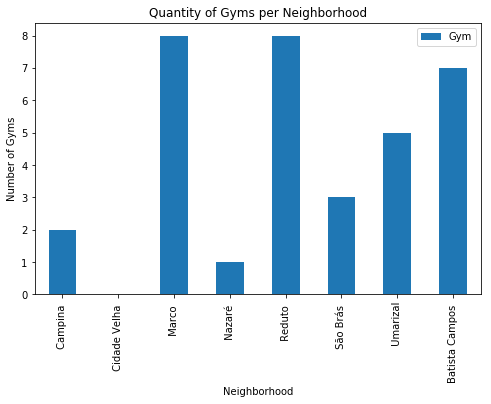

In [26]:
#Plotting the DataFrame
belem_gym_sum.plot(kind='bar', figsize=(8, 5))

plt.title('Quantity of Gyms per Neighborhood') # add a title to the histogram
plt.ylabel('Number of Gyms') # add y-label
plt.xlabel('Neighborhood') # add x-label
plt

plt.show()

The bar plot shows that "Cidade Velha" has no Gym, so that would be a good place to set up a new store; "Nazaré" and "Campina" also have veey few gyms around, so they are good places to set up the business. The other neighborhoods already have a good amount of gyms so they are not recommended to open new ones, since the possible customers would already be client of the various existing ones.

### Let's Continue the analysis

In [27]:
#Grouping the rows by Neighborhood and finding the mean of frequency for each venue category.
belem_grouped = belem_onehot.groupby('Neighborhood').mean().reset_index()
belem_grouped

,Neighborhood,Acai House,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Drugstore,Electronics Store,Event Space,Exhibit,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Mineiro Restaurant,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Music Venue,Nightclub,Northern Brazilian Restaurant,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Pastelaria,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tech Startup,Tennis Court,Theater,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Store,Water Park,Wine Bar,Wine Shop,Women's Store,Zoo Exhibit
0,Campina,0.019608,0.000000,0.019608,0.000000,0.00,0.000000,0.000000,0.000000,0.019608,0.039216,0.000000,0.000000,0.00,0.039216,0.00,0.00,0.058824,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.019608,0.039216,0.000000,0.019608,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.019608,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.019608,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.019608,0.019608,0.00,0.000000,0.000000,0.019608,0.019608,0.000000,0.039216,0.000000,0.019608,0.000000,0.039216,0.000000,0.019608,0.00,0.000000,0.019608,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.019608,0.00,0.000000,0.000000,0.019608,0.00,0.019608,0.000000,0.019608,0.019608,0.000000,0.00,0.000000,0.019608,0.000000,0.000000,0.00,0.019608,0.000000,0.000000,0.000000,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.00,0.039216,0.00,0.00,0.000000,0.019608,0.00,0.000000,0.019608,0.00,0.00,0.000000
1,Cidade Velha,0.031746,0.000000,0.015873,0.000000,0.00,0.000000,0.015873,0.047619,0.047619,0.190476,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.047619,0.000000,0.015873,0.000000,0.000000,0.000000,0.015873,0.031746,0.00,0.000000,0.000000,0.000000,0.015873,0.000000,0.015873,0.000000,0.00,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015873,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000,0.00,0.000000,0.000000,0.00000

In [28]:
#Verify the shape
belem_grouped.shape

(8, 157)

### Find the top 5 most common venues for the neighborhoods

In [29]:
num_top_venues = 5

for hood in belem_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = belem_grouped[belem_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Campina ----
                  venue  freq
0                 Plaza  0.08
1  Brazilian Restaurant  0.06
2                Church  0.04
3                 Hotel  0.04
4         Historic Site  0.04


---- Cidade Velha ----
                  venue  freq
0                   Bar  0.19
1  Brazilian Restaurant  0.05
2             BBQ Joint  0.05
3                Bakery  0.05
4                 Hotel  0.03


---- Marco ----
                  venue  freq
0              Pharmacy  0.07
1  Gym / Fitness Center  0.06
2  Brazilian Restaurant  0.05
3        Sandwich Place  0.04
4                Bakery  0.04


---- Nazaré ----
          venue  freq
0         Plaza  0.04
1        Bakery  0.04
2  Burger Joint  0.04
3      Pharmacy  0.04
4    Restaurant  0.04


---- Reduto ----
                  venue  freq
0  Gym / Fitness Center  0.06
1                   Bar  0.05
2            Restaurant  0.05
3          Dessert Shop  0.04
4          Burger Joint  0.04


---- São Brás ----
                  venue  fre

### Define a function to return the most common venues

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
#Getting the top 10 venues and adding to a new DataFrame
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Neighborhood'] = belem_grouped['Neighborhood']

for ind in np.arange(belem_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(belem_grouped.iloc[ind, :], num_top_venues)


In [32]:
#Verify
borough_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Campina,Plaza,Brazilian Restaurant,Theater,Historic Site,Bookstore,Restaurant,Church,Bar,Hotel,Electronics Store
1,Cidade Velha,Bar,BBQ Joint,Bakery,Brazilian Restaurant,Acai House,Restaurant,Park,Music Venue,Lighthouse,Hotel
2,Marco,Pharmacy,Gym / Fitness Center,Brazilian Restaurant,Sandwich Place,Bakery,BBQ Joint,Bar,Spa,Food Truck,Gymnastics Gym
3,Nazaré,Restaurant,Paper / Office Supplies Store,Burger Joint,Pharmacy,Pizza Place,Plaza,Dance Studio,BBQ Joint,Bakery,Fast Food Restaurant
4,Reduto,Gym / Fitness Center,Restaurant,Bar,Dessert Shop,Burger Joint,Nightclub,Ice Cream Shop,Cosmetics Shop,Coffee Shop,Brazilian Restaurant


### Clustering with the K-Mean Algorithm

In [33]:
#Set number of clusters to 5
kclusters = 5

belem_grouped_clustering = belem_grouped.drop('Neighborhood', 1)

#Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(belem_grouped_clustering)

#Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 4, 3, 1, 1, 1, 4])

In [34]:
#Add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

belem_merged = df_belem

#Merge belem DataFrame with the DataFrame of the sorted venues to add latitude/longitude for each neighborhood
belem_merged = belem_merged.join(borough_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [35]:
#Verify
belem_merged.head(8)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batista Campos,-1.460969,-48.489139,4,Brazilian Restaurant,Gym,Bar,Pharmacy,BBQ Joint,Bakery,Sushi Restaurant,Burger Joint,Clothing Store,French Restaurant
1,Campina,-1.451762,-48.494757,0,Plaza,Brazilian Restaurant,Theater,Historic Site,Bookstore,Restaurant,Church,Bar,Hotel,Electronics Store
2,Cidade Velha,-1.461945,-48.502750,2,Bar,BBQ Joint,Bakery,Brazilian Restaurant,Acai House,Restaurant,Park,Music Venue,Lighthouse,Hotel
3,Marco,-1.436286,-48.458978,4,Pharmacy,Gym / Fitness Center,Brazilian Restaurant,Sandwich Place,Bakery,BBQ Joint,Bar,Spa,Food Truck,Gymnastics Gym
4,Nazaré,-1.452590,-48.480983,3,Restaurant,Paper / Office Supplies Store,Burger Joint,Pharmacy,Pizza Place,Plaza,Dance Studio,BBQ Joint,Bakery,Fast Food Restaurant
5,Reduto,-1.446291,-48.492163,1,Gym / Fitness Center,Restaurant,Bar,Dessert Shop,Burger Joint,Nightclub,Ice Cream Shop,Cosmetics Shop,Coffee Shop,Brazilian Restaurant
6,São Brás,-1.451043,-48.471383,1,Bar,Restaurant,Dessert Shop,Brazilian Restaurant,Japanese Restaurant,Park,Gym / Fitness Center,Furniture / Home Store,Spa,Plaza
7,Umarizal,-1.439893,-48.484956,1,Bar,Restaurant,Pub,Japanese Restaurant,Gym / Fitness Center,Ice Cream Shop,Brazilian Restaurant,Snack Place,Food Truck,Café


### Create the Cluster Map

In [36]:
# create map
map_clusters = folium.Map(location=belem_lat_long, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(belem_merged['Latitude'], belem_merged['Longitude'], belem_merged['Neighborhood'], belem_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clusters

"Campina" is a neighborhood with lots of tourists attraction;

In [37]:
belem_merged.loc[belem_merged['Cluster Labels'] == 0, belem_merged.columns[[0] + list(range(4, belem_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Campina,Plaza,Brazilian Restaurant,Theater,Historic Site,Bookstore,Restaurant,Church,Bar,Hotel,Electronics Store


"Reduto", "São Brás" and "Umarizal" are more inclined to pubs and different kinds of restaurants;

In [38]:
belem_merged.loc[belem_merged['Cluster Labels'] == 1, belem_merged.columns[[0] + list(range(4, belem_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Reduto,Gym / Fitness Center,Restaurant,Bar,Dessert Shop,Burger Joint,Nightclub,Ice Cream Shop,Cosmetics Shop,Coffee Shop,Brazilian Restaurant
6,São Brás,Bar,Restaurant,Dessert Shop,Brazilian Restaurant,Japanese Restaurant,Park,Gym / Fitness Center,Furniture / Home Store,Spa,Plaza
7,Umarizal,Bar,Restaurant,Pub,Japanese Restaurant,Gym / Fitness Center,Ice Cream Shop,Brazilian Restaurant,Snack Place,Food Truck,Café


"Cidade Velha" is a good place for the local cuisine

In [39]:
belem_merged.loc[belem_merged['Cluster Labels'] == 2, belem_merged.columns[[0] + list(range(4, belem_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Cidade Velha,Bar,BBQ Joint,Bakery,Brazilian Restaurant,Acai House,Restaurant,Park,Music Venue,Lighthouse,Hotel


"Nazaré" has lots of general stores and restaurants

In [40]:
belem_merged.loc[belem_merged['Cluster Labels'] == 3, belem_merged.columns[[0] + list(range(4, belem_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Nazaré,Restaurant,Paper / Office Supplies Store,Burger Joint,Pharmacy,Pizza Place,Plaza,Dance Studio,BBQ Joint,Bakery,Fast Food Restaurant


"Batista Campos" and "Marco" are aggregated by Gyms, Pharmacies and local restaurants

In [41]:
belem_merged.loc[belem_merged['Cluster Labels'] == 4, belem_merged.columns[[0] + list(range(4, belem_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batista Campos,Brazilian Restaurant,Gym,Bar,Pharmacy,BBQ Joint,Bakery,Sushi Restaurant,Burger Joint,Clothing Store,French Restaurant
3,Marco,Pharmacy,Gym / Fitness Center,Brazilian Restaurant,Sandwich Place,Bakery,BBQ Joint,Bar,Spa,Food Truck,Gymnastics Gym


### Conclusion
Belém is not a big city compared to São Paulo or Rio de Janeiro, so the center of the city is not that big, but it has a good population density on these neighborhoods.

Some people tend to go to squares on the city to jog/train, but the neighborhood "Cidade Velha" doesn't have a good square for people to do this. The possibility of a new Gym in the neighborhood is a good chance to attract customer and stabilish the only Gym in the vicinity.

The most common venues were also explored on these neighborhood and, on a further analysis, we can see that restaurants and pubs have a big presence on all of them, so opening these kind of venues are not recommended in the center of the city.